In [1]:
import numpy as np
import os
import scipy.io
import h5py
import matplotlib.pyplot as plt
from scipy.signal import hilbert, chirp
from scipy import signal
import importlib
from pathlib import Path
import scipy.stats as st
import astropy.stats 
import pandas as pd
import random
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import inconsistent
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import PGanalysis
import phase_analysis
import odor_phase_analysis

## This notebook contains code to generate Figure 5, supplement 2

In [164]:
# load the data 
shiva_data = np.load(r'C:\Users\rmb55\most_updated_pattern_stim\pattern_stim_analysis\odor_analysis\shiva_odor_responses.npy', allow_pickle = True)[0]

In [165]:
# reformat the time-aligned rasters
time_aligned_rasters_expt = shiva_data['spike_rasters_expt']
formatted_rasters_cell = odor_phase_analysis.reformat_time_aligned_rasters(time_aligned_rasters_expt)

In [166]:
# concatenate the rasters for all cells across experiments
time_aligned_rasters_cat = np.array([expt for expts in formatted_rasters_cell for expt in expts], dtype = object)

### For these analyses, we will take spikes occuring over a set period of time. Let's choose a period of time that approximates a single odor-evoked breath cycle. 

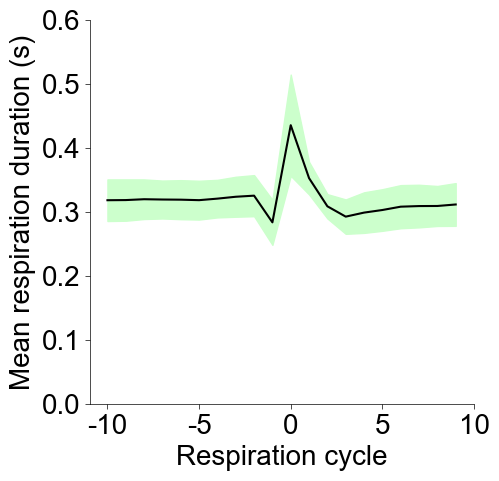

In [167]:
# load the matrix containing the 20 inhalations surrounding odor onset for each trial
inhalation_mat = shiva_data['pre_post_inhalation_mat_expt']
# now we will find the mean length of the first respiration after odor inhalation across experiments (this occurs at index 10 in the inhalation mat))
expt_mean_breath = np.empty((len(inhalation_mat), inhalation_mat[0].shape[1]-1))
fs = 30000 # the sampling rate
for expt in range(len(inhalation_mat)):
    expt_mean_breath[expt,:] = np.mean((np.diff(inhalation_mat[expt])[:,:]/fs),0)

# plot respiration cycle duration as a function of respiration number relative to odor onset
expt_mean_breath_mean = np.mean(expt_mean_breath,0)
expt_mean_breath_std = np.std(expt_mean_breath,0)
plt.plot(expt_mean_breath_mean,'k')
ax = plt.gca()
ax.fill_between(np.arange(0,20), expt_mean_breath_mean - expt_mean_breath_std, expt_mean_breath_mean + expt_mean_breath_std, color = [.8,1,.8])
plt.ylim(0,.6)
plt.ylabel('Mean respiration duration (s)')
plt.xlabel('Respiration cycle')
plt.xticks(np.arange(0,25,5), labels = [str(resp_num) for resp_num in np.arange(-10,15,5)])
PGanalysis.axis_fixer(ratio = 1, size = 20)

In [168]:
# get the mean respiration duration for the first inhalation after odor onset
mean_resp_duration = expt_mean_breath_mean[10]
print('mean respiration duration = ' + str(mean_resp_duration) + 's')

mean respiration duration = 0.4349949116161616s


### Next, we will ask how spike timing varies within this window for each cell

In [169]:
# get the spike counts for the time-aligned trials
spike_counts_time = odor_phase_analysis.get_spike_counts(time_aligned_rasters_cat, 0, mean_resp_duration)

In [170]:
# identify significantly activated cells 
n_total_cells = time_aligned_rasters_cat.shape[0]
n_odors = time_aligned_rasters_cat.shape[1]

cells_activated = np.zeros((n_total_cells,n_odors))
cells_suppressed = np.zeros((n_total_cells,n_odors))
p_vals_all = np.zeros((n_total_cells,n_odors))
for odor_num in range(n_odors):
    # get the number of spikes for the selected odor 
    p1 = spike_counts_time[:,odor_num, :]
    # get the number of spikes in response to mineral oil 
    p2 = spike_counts_time[:,0,:]
    # perform a significance test to find significantly activated and suppressed cells
    pvals,auroc = PGanalysis.twoptn_rank_sum_test(p1,p2)
    p_vals_all[:, odor_num] = pvals
    cells_activated[(np.where((pvals<.01) & (auroc>.5))[0]), odor_num] = 1
    cells_suppressed[(np.where((pvals<.01) & (auroc<.5))[0]), odor_num] = 1

In [220]:
# for each trial, get the mean spike latency within the specified time window
mean_spike_latencies = odor_phase_analysis.get_mean_spike_latencies(time_aligned_rasters_cat, 0, mean_resp_duration)

In [204]:
# get the mean phase of spikes for each cell in response to each odor for significantly activated cells
trial_mean_n_spikes = np.zeros((n_total_cells,n_odors))+np.nan
trial_mean_latency = np.zeros((n_total_cells,n_odors))+np.nan
for cell_n, cell in enumerate(mean_spike_latencies):
    for odor_n, odor in enumerate(cell):
        if sum(~np.isnan(odor))>0:
            trial_mean_latency[cell_n, odor_n] = np.mean(odor[~np.isnan(odor)])
            trial_mean_n_spikes[cell_n, odor_n]  = np.nanmean(mean_spike_latencies[cell_n,odor_n])
        else:
            trial_mean_latency[cell_n, odor_n] = np.nan
            trial_mean_n_spikes[cell_n, odor_n] = np.nan

In [205]:
# now for each cell, extract the response latencies only for significantly actvating odors. 
all_mean_latencies = []
pref_latency = []
for cell_n, cell in enumerate(cells_activated):
    # get the latencies for significantly activating odors 
    latencies_activated_cells = trial_mean_latency[cell_n, np.where(cell>0)[0]]
    # get the number of spikes evoked by each significantly activating odor
    act_idx = np.where(cell>0)[0]
    spikes_act_idx = trial_mean_n_spikes[cell_n, act_idx]
    # if cell responds to more than one odor, append response latencies to nested list 
    if len(latencies_activated_cells)>1:
        # for each set of latencies, sort the latencies by the number of spikes evoked by each odor. In each array, the first element is the preferred odorant.
        all_mean_latencies.append(latencies_activated_cells[np.flipud(np.argsort(spikes_act_idx))])

In [206]:
# calculate the mean latency for each cell...
mean_mean_latencies = []
for cell in all_mean_latencies:
    mean_mean_latencies.append(scipy.stats.circmean(cell))
# and sort the cells in ascending order by mean latency 
sort_order = np.flipud(np.argsort(mean_mean_latencies))

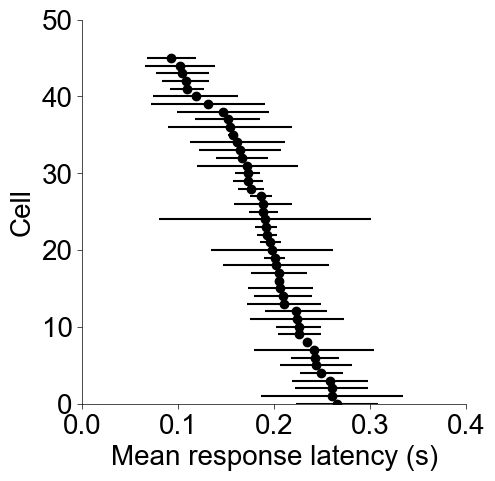

In [207]:
# plot the mean and standard deviation of response latency for each cell across odors 
all_mean_latencies_sorted = []
all_cell_indices_sorted = []
all_latency_standard_deviations = []
cell_n = 0
for cell in sort_order:
    # only include cells responding to at least three odor stimuli 
    if len(all_mean_latencies[cell])>2:
        plt.plot(np.mean(all_mean_latencies[cell]), cell_n,'ko')
        plt.errorbar(np.mean(all_mean_latencies[cell]), cell_n, xerr = np.std(all_mean_latencies[cell]), color = 'k')
        all_mean_latencies_sorted.append(all_mean_latencies[cell])
        all_cell_indices_sorted.append(np.zeros(len(all_mean_latencies[cell]))+cell_n)
        all_latency_standard_deviations.append(np.std(all_mean_latencies[cell]))
        cell_n+=1
plt.xlim(0,.4)
plt.ylim(0,50)
plt.ylabel('Cell')
plt.xlabel('Mean response latency (s)')
PGanalysis.axis_fixer(ratio = 1, size = 20)
#plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig5\mean_std_response_phase.pdf', bbox_inches = 'tight')

In [208]:
np.mean(all_latency_standard_deviations)

0.033464999582099995

In [209]:
all_mean_latencies_sorted_flat = [latency for latencies in all_mean_latencies_sorted for latency in latencies]
bootstrapped_stds = np.empty(1000)
for iteration in range(1000):
    random.seed(iteration)
    new_shuffled_std = []
    random.shuffle(all_mean_latencies_sorted_flat)
    idx = 0
    for cell in all_mean_latencies_sorted:
        grab_n = len(cell)
        new_shuffled_std.append(np.std(all_mean_latencies_sorted_flat[idx:idx+grab_n]))
        idx += grab_n
    bootstrapped_stds[iteration] = np.mean(new_shuffled_std)

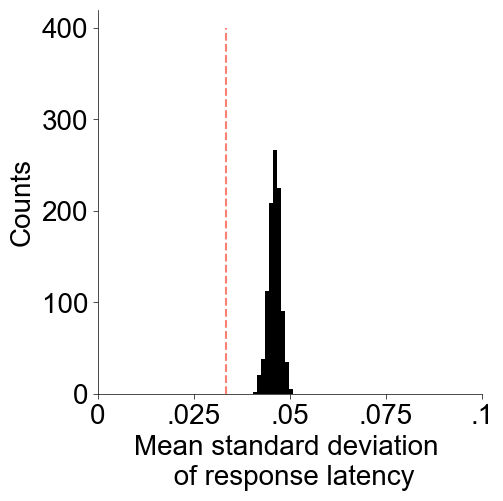

In [210]:
# plot a histogram of the mean standard deviations across 1000 iterations of randomly generated preferred phases
# additionally, plot the observed mean 
plt.hist(bootstrapped_stds, color = 'k')
std_mean_observed = np.mean(all_latency_standard_deviations)
plt.plot([std_mean_observed, std_mean_observed], [0,400], linestyle = '--', color = 'salmon')
plt.xlabel('Mean standard deviation \n of response latency')
plt.ylabel('Counts')
plt.xlim(0,.1)
plt.xticks([0,.025,.05,.075,.1], labels = ['0','.025','.05','.075','.1'])
PGanalysis.axis_fixer(ratio = 1, size = 20)
#plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig5\bootstrapped_std.pdf', bbox_inches = 'tight')

### Next, we will compute the PSTH consistency within a time window of ~2 respirations

In [211]:
time_aligned_PSTHs_expt_cat = np.array([expt for expts in shiva_data['time_aligned_PSTHs_expt'] for expt in expts])
x = np.arange(-5,5,.002)
analyze_resp = np.where((x>0) & (x<mean_resp_duration*2))[0]
time_aligned_psth_analyze = time_aligned_PSTHs_expt_cat[:,:,:,analyze_resp]
time_aligned_psth_analyze_mean = np.mean(time_aligned_psth_analyze,2)

In [212]:
analyze_indices_pre = np.where((x>mean_resp_duration*-2)&(x<0))[0][0:]
spontaneous_PSTHs = np.mean(time_aligned_PSTHs_expt_cat[:, :, :, analyze_indices_pre[0:-1]],(1,2))

In [213]:
# First, compute the PSTH consistency for all odor pairs
similarity_mats_odors = odor_phase_analysis.get_PSTH_consistency(cells_activated, time_aligned_psth_analyze_mean)
odor_mean_distances = []
for mat in similarity_mats_odors:
    odor_mean_distances.append(np.nanmean(mat))

In [214]:
# Next, perform a shuffled control (shuffle cell identity) for all odor pairs
similarity_mats_shuff = odor_phase_analysis.get_PSTH_consistency_shuff(cells_activated, time_aligned_psth_analyze_mean)
odor_mean_distances_shuff = []
for mat in similarity_mats_shuff:
    odor_mean_distances_shuff.append(np.nanmean(mat))

In [215]:
# Next, perform a shuffled control (shuffle cell identity) for all odor pairs
similarity_mats_spont = odor_phase_analysis.get_PSTH_consistency_spont(cells_activated, time_aligned_psth_analyze_mean, spontaneous_PSTHs)
spont_mean_distances = []
for mat in similarity_mats_spont:
    spont_mean_distances.append(np.nanmean(mat))

In [216]:
# Finally, perform a shuffled control (shuffle cell identity) for all spontaneous-acivity to odor-evoked response comparisons
similarity_mats_spont_shuff = odor_phase_analysis.get_PSTH_consistency_spont_shuff(cells_activated, time_aligned_psth_analyze_mean, spontaneous_PSTHs)
spont_mean_distances_shuff = []
for mat in similarity_mats_spont_shuff:
    spont_mean_distances_shuff.append(np.nanmean(mat))

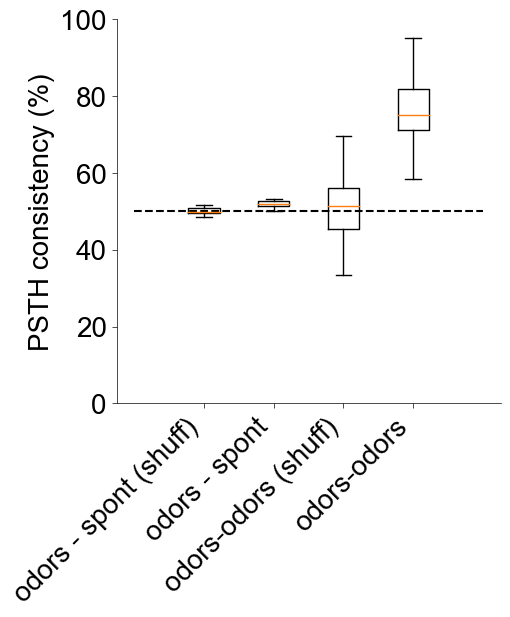

In [217]:
plt.boxplot([spont_mean_distances_shuff, spont_mean_distances, odor_mean_distances_shuff, odor_mean_distances], showfliers = False)
plt.ylim(0,1)
plt.plot([0,5],[.5,.5],'k--')
plt.ylabel('PSTH consistency (%)')
plt.xticks([1,2,3,4], ['odors - spont (shuff)', 'odors - spont', 'odors-odors (shuff)', 'odors-odors'], rotation = 45, ha = 'right')
plt.yticks([0,.2,.4,.6,.8,1], labels = ['0','20','40','60','80','100'])
PGanalysis.axis_fixer(ratio = 1, size = 20)

### Finally, we want to know if high consistency across odor stimuli can be explained by chemical similarity of the odorants, as opposed to the intrinsic properties of cells
### To test this, we will ask whether PSTH consistency increases as pairs of odorants become more similar. 
### We will compute the morgan similarity matrix for all odorants, and then assess the correlation between odor similarity and response consistency. 

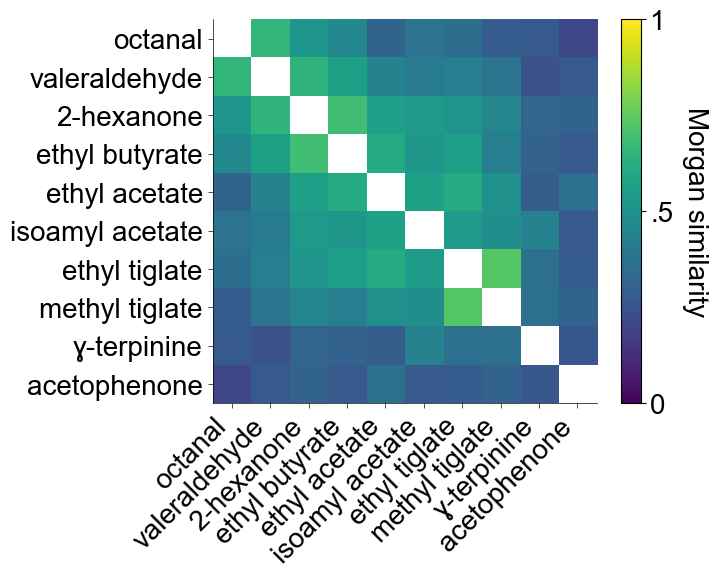

In [186]:
# Perform hierarchical clustering to visualize the odor similarity matrix
morgan_similarity_mat = np.load(r'Z:\robin\thesis\figures\chapter4\data\morgan_similarity_shiva.npy', allow_pickle = True)

np.fill_diagonal(morgan_similarity_mat, 1)

df = pd.DataFrame(morgan_similarity_mat, columns=[f'Item_{i+1}' for i in range(10)])

# Perform hierarchical clustering
linkage_matrix = hierarchy.linkage(df, method='average', metric='euclidean', optimal_ordering = 1)

# Sort the correlation matrix based on the dendrogram
sorted_indices = hierarchy.leaves_list(linkage_matrix)

sorted_indices = hierarchy.leaves_list(linkage_matrix)
sorted_df = df.iloc[sorted_indices, sorted_indices]

odors = ['min oil', '2-hexanone', 'octanal', 'isoamyl acetate', 'ethyl butyrate', 'valeraldehyde', 'ethyl tiglate', 'acetophenone', 'ɣ-terpinine', 'ethyl acetate', 'methyl tiglate']
sorted_odors = np.array(odors[1:])[sorted_indices.astype(int)]

sorted_morgan = sorted_df.to_numpy()
np.fill_diagonal(sorted_morgan, np.nan)
plt.imshow(sorted_morgan)
plt.clim(0,1)
plt.xticks(np.arange(10), labels = sorted_odors, rotation = 45, horizontalalignment = 'right')
plt.yticks(np.arange(10), labels = sorted_odors)

ax = plt.gca()
cbar = plt.colorbar(ticks = [0,.5,1])
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('Morgan similarity', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_yticklabels(['0','.5','1'])
PGanalysis.axis_fixer(ratio = 1, size = 20)

### Now, we will determine whether odorant structure predicts similarities in population response dynamics (in time coordinates) to these odors

In [187]:
all_similarity = []
for mat in similarity_mats_odors:
    # get the proportion of ones (dii<dij) in the similarity matrix. 
    # each matrix is size n_cells x n_cells that responded to the odor pair. For each pair of cells, if the distance between cell 1's response to odor 1 and odor 2 is less than the distance between cell 1's response to odor 1 and cell 2's response to odor 2, then the matrix contains a 1.
    # Here we calculate the percentage of pairs for which the similarity between odor 1 and 2 for a given cell is greater than the similarity between two different cell's responses to odor 1 and 2. 
    similarity = np.nanmean(mat)
    all_similarity.append(similarity)

In [188]:
# Reshape data into a matrix of average similarity metrics 
odor_similarity_mat = np.empty((len(sorted_odors),len(sorted_odors)))
counter = 0
for odor1 in range(len(sorted_odors)):
    for odor2 in range(len(sorted_odors)):
        if odor1 == odor2:
            odor_similarity_mat[odor1,odor2] = np.nan
        else:
            odor_similarity_mat[odor1,odor2] = all_similarity[counter]
            counter+=1

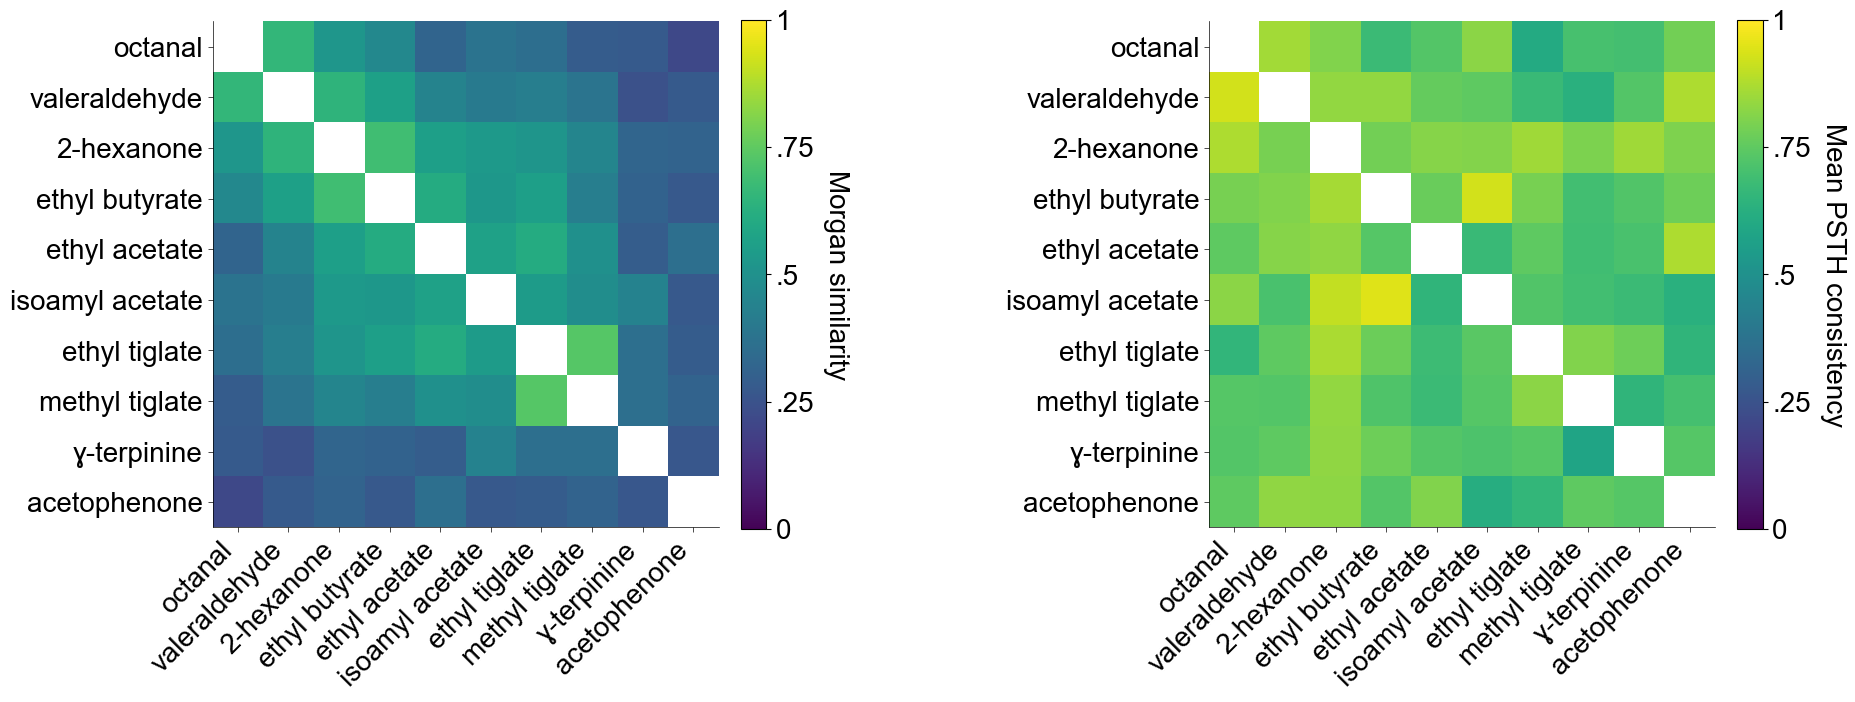

In [189]:
plt.figure(figsize = (20,20))

plt.subplot(1,2,1)
ax = plt.gca()
plt.imshow(sorted_morgan)
plt.clim(0,1)
plt.xticks(np.arange(10), labels = sorted_odors, rotation = 45, horizontalalignment = 'right')
plt.yticks(np.arange(10), labels = sorted_odors)


cbar = plt.colorbar(ticks = [0,.25,.5,.75,1],fraction=0.046, pad=0.04)
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('Morgan similarity', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_yticklabels(['0','.25','.5','.75','1'])
PGanalysis.axis_fixer(ratio = 1, size = 20)

plt.subplot(1,2,2)
# use the indices of the sorted odors to plot the PSTH consistency matrix
odor_similarity_mat = pd.DataFrame(odor_similarity_mat, columns=[f'Item_{i+1}' for i in range(10)])
sorted_odor_similarity_mat = odor_similarity_mat.iloc[sorted_indices, sorted_indices]
plt.imshow(sorted_odor_similarity_mat)
plt.clim(0,1)
plt.xticks(np.arange(10), labels = sorted_odors, rotation = 45, horizontalalignment = 'right')
plt.yticks(np.arange(10), labels = sorted_odors)
ax = plt.gca()
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('Mean PSTH consistency', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.set_ticks([0,.25,.5,.75,1])
cbar.ax.set_yticklabels(['0','.25','.5','.75','1'])
PGanalysis.axis_fixer(ratio = 1, size = 20)

### Plot PSTH consistency vs. odor response similarity 

[[1.         0.35150988]
 [0.35150988 1.        ]]


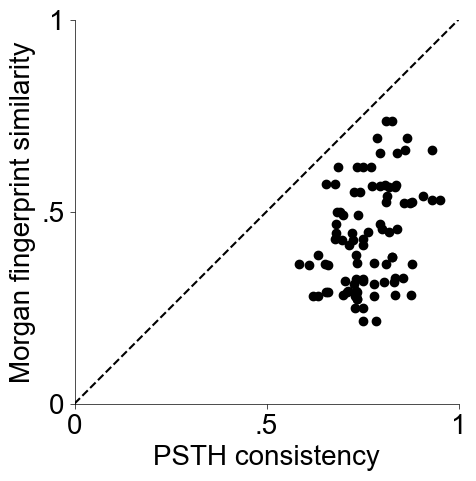

In [190]:
# now, plot the odor similarity vs consistency for each odor pair, then calculate the correlation between these two variables. 
sorted_morgan_similarity_ravel = np.ravel(sorted_morgan)
sorted_morgan_similarity_ravel = sorted_morgan_similarity_ravel[~np.isnan(sorted_morgan_similarity_ravel)]
sorted_odor_similarity_mat_ravel = np.ravel(sorted_odor_similarity_mat)
sorted_odor_similarity_mat_ravel = sorted_odor_similarity_mat_ravel[~np.isnan(sorted_odor_similarity_mat_ravel)]
plt.plot(sorted_odor_similarity_mat_ravel, sorted_morgan_similarity_ravel,'ko')
print(np.corrcoef(sorted_odor_similarity_mat_ravel, sorted_morgan_similarity_ravel))
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot([0,1],[0,1],'k--')
plt.xticks([0,.5,1], ['0','.5','1'])
plt.yticks([0,.5,1], ['0','.5','1'])
plt.xlabel('PSTH consistency')
plt.ylabel('Morgan fingerprint similarity')
PGanalysis.axis_fixer(ratio = 1, size = 20)

### PSTH consistency (using time coordinates) is signficantly correlated with odorant structure (morgan similarity)

In [191]:
scipy.stats.pearsonr(sorted_odor_similarity_mat_ravel, sorted_morgan_similarity_ravel)

(0.3515098789979808, 0.0006807992441954137)

### Finally, as a positive control, let's see whether the number of spikes fired by a given cell is determined by odor identity

In [192]:
# get the spike counts for the time-aligned trials
spike_counts_response_period = odor_phase_analysis.get_spike_counts(time_aligned_rasters_cat,0,mean_resp_duration*2)
spike_counts_pre = odor_phase_analysis.get_spike_counts(time_aligned_rasters_cat, mean_resp_duration*-2,0)

In [193]:
# for each cell compute mean and standard deviation of pre-inhalation spikes:
spike_counts_pre_mean = np.mean(spike_counts_pre, (1,2))
spike_counts_pre_std = np.std(spike_counts_pre, (1,2))

### Compute the z-scored matrix using the distribution of pre-odor spikes

In [194]:
trial_mean_spike_counts = np.mean(spike_counts_response_period ,2)

mean_spike_count_correlation_matrix = np.empty((10, 10))
for odor_idx1, odor1 in enumerate(range(1,11)):
    for odor_idx2, odor2 in enumerate(range(1,11)):
            mean_spike_count_correlation_matrix[odor_idx1, odor_idx2] = np.corrcoef((trial_mean_spike_counts[:,odor1]-spike_counts_pre_mean)/spike_counts_pre_std, (trial_mean_spike_counts[:,odor2]-spike_counts_pre_mean)/spike_counts_pre_std)[0,1]

### Plot the odor structure and spike count correlation matrices sorted by odorant similarity

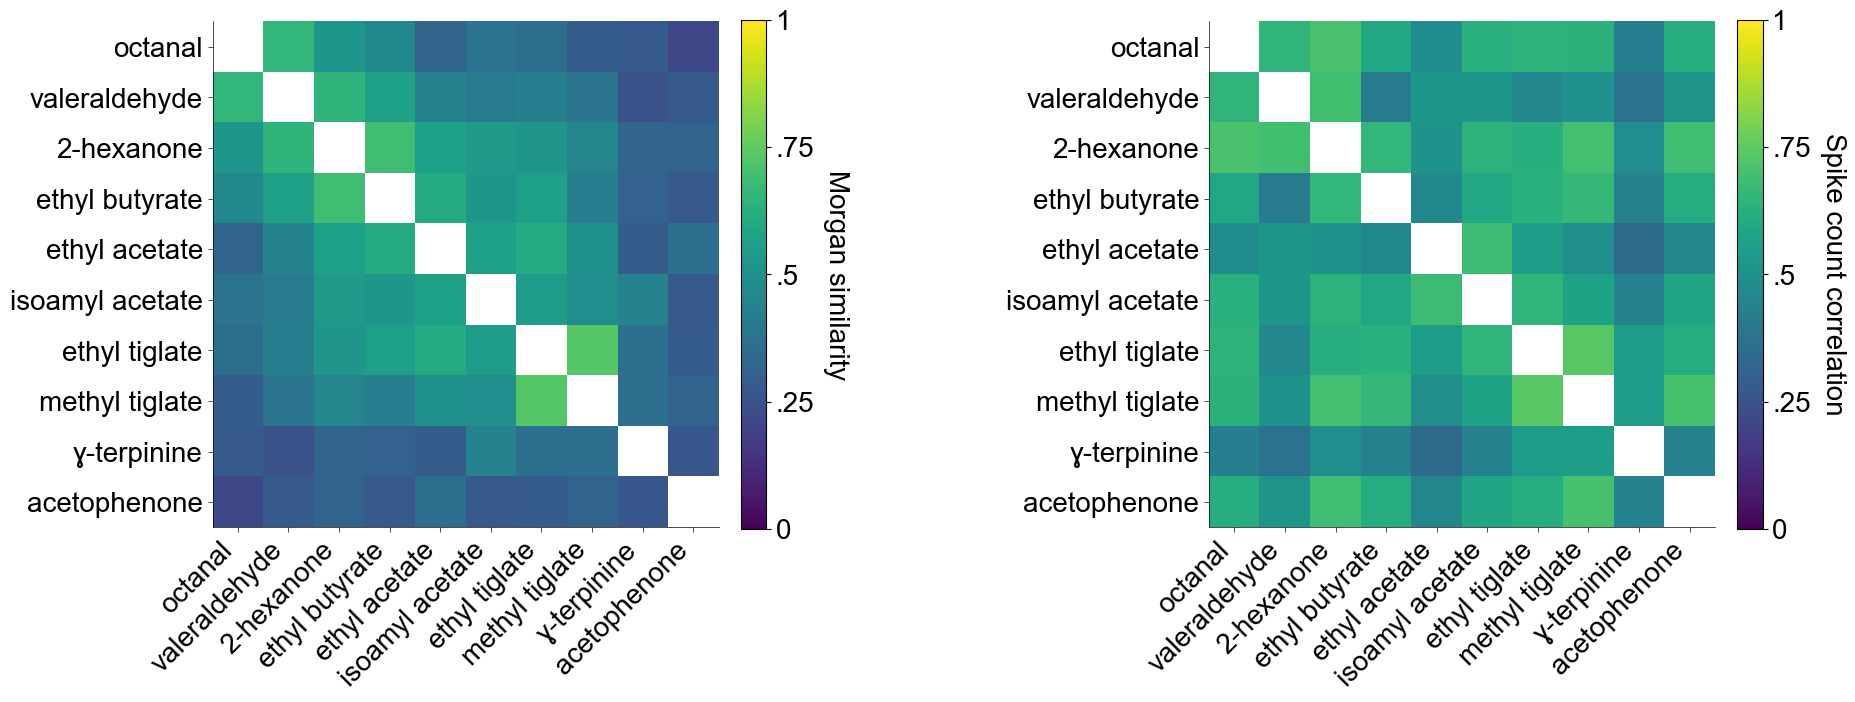

In [195]:
plt.figure(figsize = (20,20))

plt.subplot(1,2,1)
ax = plt.gca()
plt.imshow(sorted_morgan)
plt.clim(0,1)
plt.xticks(np.arange(10), labels = sorted_odors, rotation = 45, horizontalalignment = 'right')
plt.yticks(np.arange(10), labels = sorted_odors)


cbar = plt.colorbar(ticks = [0,.25,.5,.75,1],fraction=0.046, pad=0.04)
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('Morgan similarity', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_yticklabels(['0','.25','.5','.75','1'])
PGanalysis.axis_fixer(ratio = 1, size = 20)

plt.subplot(1,2,2)
np.fill_diagonal(mean_spike_count_correlation_matrix, np.nan)
df = pd.DataFrame(mean_spike_count_correlation_matrix, columns=[f'Item_{i+1}' for i in range(10)])
sorted_spike_count_correlation_matrix = df.iloc[sorted_indices, sorted_indices]
plt.imshow(sorted_spike_count_correlation_matrix)
plt.clim(0,1)
plt.xticks(np.arange(10), labels = sorted_odors, rotation = 45, horizontalalignment = 'right')
plt.yticks(np.arange(10), labels = sorted_odors)

cbar = plt.colorbar(ticks = [0,.25,.5,.75,1],fraction=0.046, pad=0.04)
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('Spike count correlation', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_yticklabels(['0','.25','.5','.75','1'])
PGanalysis.axis_fixer(ratio = 1, size = 20)

[[1.         0.36518896]
 [0.36518896 1.        ]]


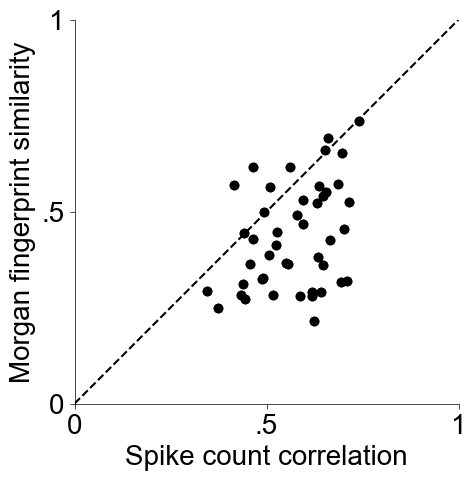

In [196]:
sorted_spike_count_correlation_ravel = np.ravel(sorted_spike_count_correlation_matrix)
sorted_spike_count_correlation_ravel = sorted_spike_count_correlation_ravel[~np.isnan(sorted_spike_count_correlation_ravel)]
plt.plot(sorted_spike_count_correlation_ravel,sorted_morgan_similarity_ravel,'ko')
print(np.corrcoef(sorted_spike_count_correlation_ravel, sorted_morgan_similarity_ravel))
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot([0,1],[0,1],'k--')
plt.xticks([0,.5,1], ['0','.5','1'])
plt.yticks([0,.5,1], ['0','.5','1'])
plt.xlabel('Spike count correlation')
plt.ylabel('Morgan fingerprint similarity')
PGanalysis.axis_fixer(ratio = 1, size = 20)

### Spike count correlations are significantly correlated with odorant structure (morgan similarity)

In [197]:
scipy.stats.pearsonr(sorted_spike_count_correlation_ravel,  sorted_morgan_similarity_ravel)

(0.36518896375933885, 0.0004014623580239631)